# 多任务学习 multi-task learning
1. 多任务学习能够同时处理和学习多个相关任务，将多个互相关联的任务联合训练，从而提高模型的泛化能力和效果，使用一个或多个输入用于预测几个不同输出。
2. 在多任务学习中，多个不同的任务使用同一网络模型，模型同时学习多个任务的知识，从而更好地利用训练数据进行训练。例如，在自动驾驶中，模型需要识别障碍物、规划路线、提供适量的油门制动和转向等，通过考虑相同的输入集(来自多个传感器)实时完成这些任务。
3. 模型分析，我们将学习如何在单个前向传递中同时进行连续值预测和离散值(类别)预测。构建模型策略如下:
    - 导入相关库
    - 获取包含人物图像、性别和年龄信息的数据集
    - 预处理数据并创建训练和测试数据集
    - 构建模型:
        1. 特征提取层使用预训练VGG19模型
        2. 创建两个分支独立层，其中一层对应于年龄估计，另一层对应于性别分类
        3. 每个输出分支都有不同的损失函数，年龄是一个连续值(计算 mse 或 mae 损失)，而性别D是一个分类值(计算交叉熵损失)
        4. 对年龄估计损失和性别分类损失加权求
        5. 通过反向传播优化权重值来最小化整体损失
    - 训练模型并预测新图像

In [1]:
import torch
import numpy as np, cv2, pandas as pd, time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
device = 'cuda' if torch.cuda.is_available() else 'cpu'


/home/lenovo/anaconda3/envs/Explan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


为了构建多分类模型，我们将使用 FairFace 数据集， FairFace 数据集是一个用于面部分析和人脸识别的多样性人脸数据集，由Fairface 团队于 2019 年发布。 

FairFace 数据集的目标是提供一个包含多种族、性别和年龄的真实世界人脸图像集合，以便研究人员可以训练和评估面部识别算法在多样性群体中的表现。该数据集包含了 87,022 个标记的人脸图像，

In [2]:
trn_df = pd.read_csv('fairface-labels-train.csv')
val_df = pd.read_csv('fairface-labels-val.csv')
print(trn_df.head())

          file  age  gender        race  service_test
0  train/1.jpg   59    Male  East Asian          True
1  train/2.jpg   39  Female      Indian         False
2  train/3.jpg   11  Female       Black         False
3  train/4.jpg   26  Female      Indian          True
4  train/5.jpg   26  Female      Indian          True


In [3]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
    # 返回输入图像数量
    def __len__(self):
        return len(self.df)
    
    # 获取给定位置 ix 的图像信息
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gen
    
    # 图像预处理，大小、通道、归一化
    def preprocess_image(self, im):
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2,0,1)  # 本身维度 是 （0 1 2）
        im = self.normalize(im/255.)
        return im[None]

    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im) # 处理图像
            ims.append(im)

            ages.append(float(int(age)/80)) # 缩放年龄 /最大年龄80,值变为0-1（目的：避免梯度消失，在后处理期间还原）
            genders.append(float(gender)) # 性别转换为 浮点值

        # 都转换为 张量并返回
        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages, genders


In [4]:
cv2.imread('train/3204.jpg')

array([[[156, 156, 156],
        [155, 155, 155],
        [153, 153, 153],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[157, 157, 157],
        [156, 156, 156],
        [154, 154, 154],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[158, 158, 158],
        [157, 157, 157],
        [155, 155, 155],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       ...,

       [[156, 156, 156],
        [155, 155, 155],
        [153, 153, 153],
        ...,
        [ 83,  83,  83],
        [ 83,  83,  83],
        [ 85,  85,  85]],

       [[155, 155, 155],
        [154, 154, 154],
        [152, 152, 152],
        ...,
        [ 81,  81,  81],
        [ 81,  81,  81],
        [ 82,  82,  82]],

       [[156, 156, 156],
        [154, 154, 154],
        [152, 152, 152],
        ...,
        [ 81,  81,  81],
        [ 80,  80,  80],
        [ 81,  81,  81]]

In [7]:
trn = GenderAgeClass(trn_df) # 训练集
val = GenderAgeClass(val_df) # 验证集

train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)
a,b,c, = next(iter(train_loader))
print(b)
print(a.shape, b.shape, c.shape)
# torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


tensor([0.3500, 0.3750, 0.5375, 0.4375, 0.2625, 0.4250, 0.4500, 0.0500, 0.1250,
        0.5375, 0.1750, 0.4875, 0.4750, 0.3250, 0.3125, 0.4625, 0.2000, 0.4875,
        0.3000, 0.0750, 0.4000, 0.5625, 0.6250, 0.4375, 0.4750, 0.1000, 0.1750,
        0.4250, 0.6250, 0.3625, 0.3125, 0.0875], device='cuda:0')
torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


In [8]:
def get_model():
    model = models.vgg16(pretrained = True)

    # 冻结加载模型的参数
    for param in model.parameters():
        param.requires_grad = False  
    
    # 使用自定义网络 替换avgpool层
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )

    # 创建包含两个输出分支的分类器 
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()

            # 定义中间层
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )

            self.age_classifier = nn.Sequential( 
                nn.Linear(64, 1),
                nn.Sigmoid() # 年龄输出介于0-1
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid() # 性别输出是0/1
            )

        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age

    model.classifier = ageGenderClassifier()
    
    gender_criterion = nn.BCELoss() # 性别分类的二元交叉熵损失
    age_criterion = nn.L1Loss() #年龄分类的L1损失
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
    
    return model.to(device), loss_functions, optimizer

# 初始化变量中的值
model, loss_functions, optimizer = get_model()  

In [9]:
# 图像、性别、年龄、模型、优化器、loss 作为输入计算总损失
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad() # 优化器重置
    pred_gender, pred_age = model(ims)  # 计算性别、年龄的预测值
    
    gender_criterion, age_criterion = criteria
    # 压缩预测形状为（batch_size,1），整形为和目标值相同形状 batch_size
    gender_loss = gender_criterion(pred_gender.squeeze(), gender) 
    age_loss = age_criterion(pred_age.squeeze(), age)
    
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(data, model, criteria):
    # 模型评估阶段，不需要 梯度计算
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
        pred_gender, pred_age = model(ims)
    
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)

    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_acc, age_mae


In [10]:
# 开始训练模型，
model, criteria, optimizer = get_model()
# 定义存储 训练和测试 损失值的列表，并制定 epoch 数
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 10
best_test_loss = 1000
start = time.time()

# 每个epoch 开始前 重新初始化训练和测试的损失值
for epoch in range(n_epochs):
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)
    
    for ix, data in enumerate(train_loader):
        # if ix == 100: break
        loss = train_batch(data, model, optimizer, criteria)
        epoch_train_loss += loss.item()

    for ix, data in enumerate(test_loader):
        # if ix == 10: break
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        ctr += len(data[0]) # 测试数据总量

    val_age_mae /= ctr
    val_gender_acc /= ctr
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)

    # 输出每个epoch结束时的性能指标
    elapsed = time.time()-start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
    info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'
    print(info)

    # 存储 每个epoch中 测试数据集的年龄和性别预测的准确率
    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)


1/10 (170.42s - 1704.21s remaining)
Epoch: 001	Train Loss: 0.548	Test: 0.478	Best Test Loss: 0.4784
Gender Accuracy: 82.65%	Age MAE: 6.19

2/10 (340.80s - 1533.61s remaining)
Epoch: 002	Train Loss: 0.398	Test: 0.452	Best Test Loss: 0.4524
Gender Accuracy: 84.55%	Age MAE: 6.30



KeyboardInterrupt: 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

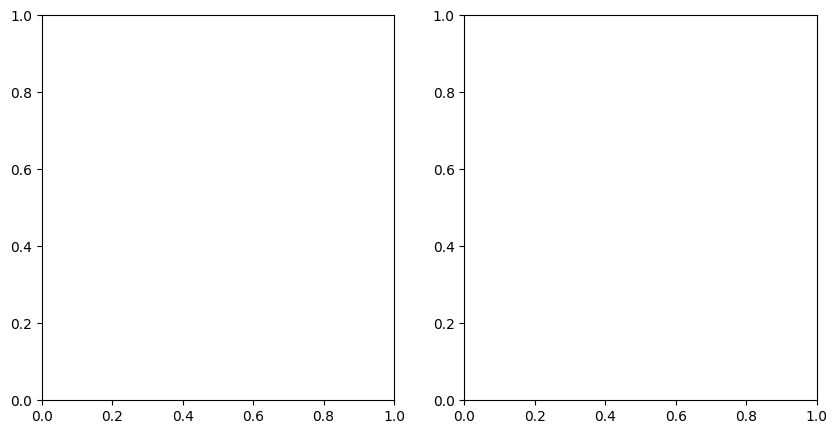

In [11]:
epochs = np.arange(1,len(val_gender_accuracies)+1)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
ax[0].plot(epochs, val_gender_accuracies, 'bo')
ax[1].plot(epochs, val_age_maes, 'r')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')
plt.show()

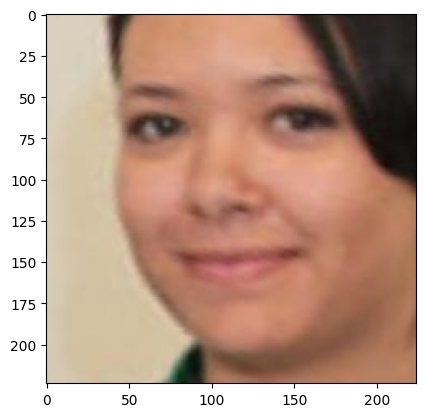

predicted gender: Female ; Predicted age 29


In [13]:
# 随机选择测试图像，预测图中人物年龄和性别
im = cv2.imread('val/4.jpg')
im = trn.preprocess_image(im).to(device)

gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

im = cv2.imread('val/4.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'), '; Predicted age', int(pred_age[0][0]*80))
# predicted gender: Female ; Predicted age 26
